# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Samuel

Last Name: Kadin

Student ID: 913351901

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3 as sql
from datetime import datetime
import geopandas as gpd
import osmnx as ox
import shapely.geometry as geom
import plotnine as gg
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Read in the data
db = sql.connect("sf_data.sqlite")

#Look at the data
pd.read_sql("SELECT * FROM sqlite_master", db)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [3]:
#Create an sql seach to select mobile food locations where the status is approved

test2 = pd.read_sql("""SELECT L.permit, L.locationid, R.permit, R.Applicant 
                       FROM mobile_food_schedule AS L INNER JOIN mobile_food_permits 
                       AS R ON L.permit = R.permit WHERE status = 'APPROVED'""", db)

In [4]:
#Drop the duplicates so that time slots are don't matter anymore
test2 = test2.drop_duplicates()

#Get the value counts for each company with the amount of locations
test2.iloc[:,3].value_counts()

Park's Catering                                                            23
D & T Catering                                                             17
F & C Catering                                                             13
Munch A Bunch                                                              10
Eva's Catering                                                              8
BH & MT LLC                                                                 7
Linda's Catering                                                            7
San Francisco Carts & Concessions, Inc. DBA Stanley's Steamers Hot Dogs     5
Golden Catering                                                             5
Bay Area Mobile Catering, Inc. dba. Taqueria Angelica's                     4
Subs on Hubs                                                                4
DO UC US Mobile Catering                                                    4
Roadside Rotisserie Corporation / Country Grill                 

### Which mobile food vendor(s) sells at the most locations?
Park's Catering Sells at the most locations, with 23 locations. 6 higher than the econd highest, which was D&T Catering with 17.

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [5]:
#Read in all the columns from the zillow table.

z = pd.read_sql("SELECT * FROM zillow", db)

#I orginally loaded in all this data, but then removed what wasn't needed

#z2011 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2010%'", db)
z2011 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2011%'", db)
#z2012 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2012%'", db)
#z2013 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2013%'", db)
z2016 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2016%'", db)

In [6]:
#Group by the date then find the mean for each group. Also drop the NA's.

zgb = z.groupby("Date").mean()
zgb = zgb.dropna()

In [7]:
#Convert the Date to datetime datatype.
z["Date"] = pd.to_datetime(z["Date"])

#Drop the NA's then group by date and find the means for each month.
zgb = z.dropna()
zgb = zgb.groupby("Date").mean()

#Check
zgb.tail()

,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
Date,,,,,
2016-03-01,94111.153846,3.863231,947.142555,21.080769,4.094900
2016-04-01,94115.066667,3.774133,945.734436,21.706000,3.702340
2016-05-01,94115.000000,3.766222,929.765871,21.090000,3.789700
2016-06-01,94114.400000,3.664667,916.368685,21.298000,3.700447
2016-07-01,94113.000000,3.732400,951.478360,20.890000,3.693000


Text(0.5,1,'Zillow Rent Index from November, 2010 to July, 2017')

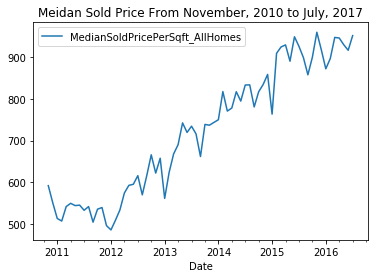

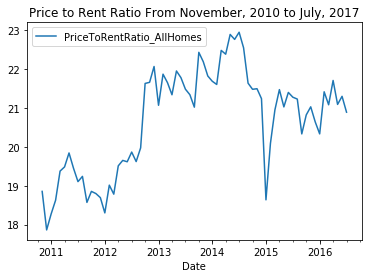

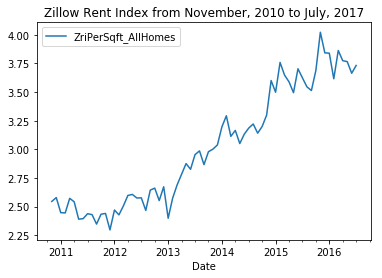

In [8]:
#Plot the variables regarding price

zgb.plot(y = 'MedianSoldPricePerSqft_AllHomes')
plt.title("Meidan Sold Price From November, 2010 to July, 2017")

zgb.plot(y = 'PriceToRentRatio_AllHomes')
plt.title("Price to Rent Ratio From November, 2010 to July, 2017")

zgb.plot(y = 'ZriPerSqft_AllHomes')
plt.title("Zillow Rent Index from November, 2010 to July, 2017")

In [9]:
#Print the means
print("2011 means\n\n",z2011.mean(),"\n\n2016 means\n\n",z2016.mean())

2011 means

 RegionName                         94116.769231
ZriPerSqft_AllHomes                    2.594013
MedianSoldPricePerSqft_AllHomes      534.653853
PriceToRentRatio_AllHomes             18.702187
Turnover_AllHomes                      4.868826
dtype: float64 

2016 means

 RegionName                         94116.769231
ZriPerSqft_AllHomes                    3.890027
MedianSoldPricePerSqft_AllHomes      930.922284
PriceToRentRatio_AllHomes             20.657986
Turnover_AllHomes                      3.963703
dtype: float64


### How have housing prices changed since 2010 in San Francisco? Has Rent increased at a higher rate than prices?

    To analyze this problem, I decided to use the time series data provided in the "Zillow" table within the San Francisco Database.  From the above plots, we can clearly see that the median price per square foot has incresed steadily from November 2010 to July 2017. Looking at 2011 (the lowest complete year) and 2016 (the highest complete year), we see that the Mean Median Selling Price Per Square Foot for a home sold was $534.65 in 2011, and $930.92 in 2016, which is an increase of $396.27, or 74.11%.  The Price to Rent Ratio, seems to increase slightly over the period, but reaches it's peak in 2014 and drops after.  This suggests that the price to rent ratio has stayed relatively flat over the past 5 years, and the fact that the Zillow Rent Index graph (which is a smoothed Rent value provided by Zillow.com) appears to mimic the Median Selling Price Per Square Foot graph further illustrates this point.

    

In [10]:
#2 Food vendor locations and Assaults

In [11]:
#Select the latitude and longitude from mobile food locaitons

mf_loc = pd.read_sql("SELECT longitude, latitude FROM mobile_food_locations", db)
mf_loc.head()

,Longitude,Latitude
0,-122.398532,37.774871
1,-122.395902,37.759304
2,-122.406007,37.765216
3,-122.400552,37.748801
4,-122.416105,37.767852


In [12]:
#Use zip to create a geom.point for mobile food locaitons

mf_lnglat = [geom.Point(x) for x in zip(mf_loc["Longitude"], mf_loc["Latitude"])]
mf_loc = gpd.GeoDataFrame(mf_loc, geometry = mf_lnglat)

#remove extranious values
mf_loc = mf_loc[mf_loc.Longitude != 0]

#create a random sample, since there were like 9,000 results (too many to plot)
mf_loc = mf_loc.sample(250)

In [13]:
#read in the assault data
assault = pd.read_sql("SELECT Category, Datetime, lon, lat FROM crime WHERE Category = 'ASSAULT'", db)

In [14]:
#Converty the assault datetime data to datetime

assault["Datetime"] = pd.to_datetime(assault["Datetime"])

#Check 
assault.dtypes

Category            object
Datetime    datetime64[ns]
Lon                float64
Lat                float64
dtype: object

In [15]:
#Create a random sample of 250 from assault data set
ass_sample = assault.sample(250)

In [16]:
#Create a geom.point variable for the assault data
lnglat = [geom.Point(x) for x in zip(ass_sample["Lon"], ass_sample["Lat"])]
ass_sample = gpd.GeoDataFrame(ass_sample, geometry = lnglat)

#check
ass_sample.head()

,Category,Datetime,Lon,Lat,geometry
89705,ASSAULT,2016-09-16 20:45:00,-122.442798,37.803863,POINT (-122.442797976347 37.8038629379154)
22540,ASSAULT,2011-01-19 01:00:00,-122.407387,37.781069,POINT (-122.407387172098 37.7810688918781)
5944,ASSAULT,2014-03-29 23:00:00,-122.412931,37.783834,POINT (-122.412930522059 37.7838344374141)
89197,ASSAULT,2016-11-20 01:40:00,-122.478326,37.764436,POINT (-122.478325615864 37.7644357771555)
36228,ASSAULT,2012-04-27 22:30:00,-122.394103,37.776383,POINT (-122.394102624525 37.7763827130285)


In [17]:
#Read in the counties shapefile

counties = gpd.read_file("SF Find Neighborhoods/geo_export_96bb9dad-f9fb-4df0-969b-f467d0b5d405.shp")

<function matplotlib.pyplot.show>

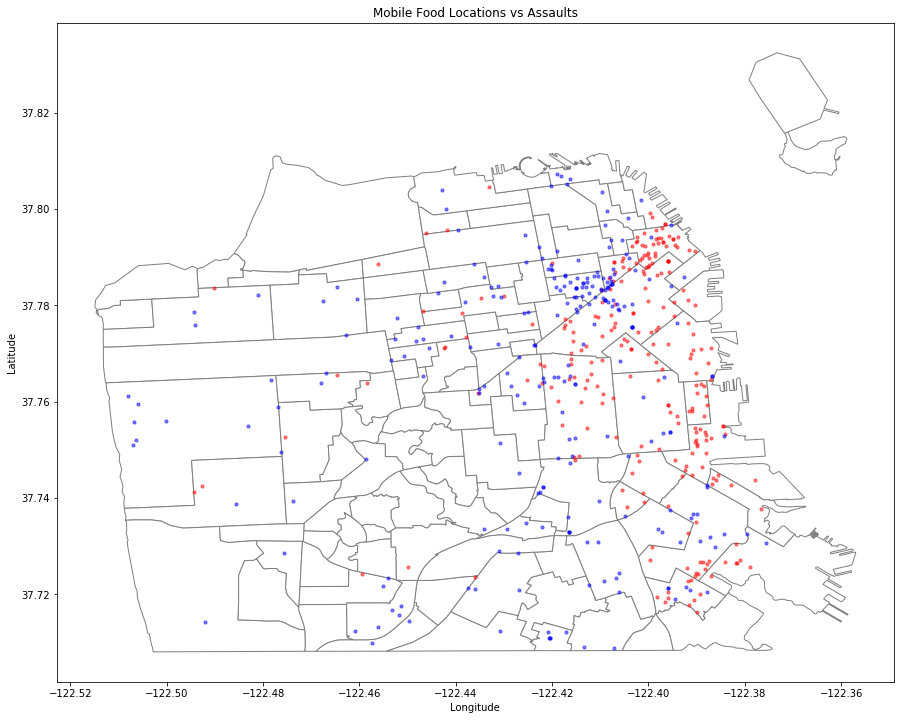

In [18]:
#Plot teh data on the map
ax = counties.plot(color = "white", edgecolor = "gray",figsize = (15,15))
mf_loc.plot(ax = ax, color = "red", alpha = 0.5, markersize = 10)
ass_sample.plot(ax = ax, color = "blue", alpha = 0.5, markersize = 10)
plt.title("Mobile Food Locations vs Assaults")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#counties.apply(add_label, axis  = 1)  #Didn't want the counties on the plot
plt.show

### Are the locations of Moblie Food Vendors associated with the locations of Assault?

    To analyze this I decided to create a map plot of of the locations of mobile food vendors and the locations of assault within the city of San Francisco.  Since there were over 90,000 cases of assault, the map would be too cluttered if I plotted all of them, so I took a random sample of 250 assaults, and plotted them against a random sample of mobile food locations.  From the above plot, from first glance it may appear that there is relation between the two in the north eastern portion of the island, but it is expected since that is the most densely populated region.  Also the mobile food vendors tend to be clustered around the downtown area, which is also expected since those tend to be commercial districts, while it appears that the assaults are clustered in teh residential portions of the city.  Thus we conclude that since mobile food locations tend to be clustered in commercial areas, and assaults tend to be clustered in commercial areas, there is little evidence to suggest there is positive association between the areas of Mobile food vendors and the locations of Assaults.  There is potentially some negative association though.

In [19]:
#3 total crimes, crimes during day, crimes during night

crimes = pd.read_sql("SELECT Datetime, Lon,Lat FROM crime WHERE Category != 'NON-CRIMINAL'", db)
crimes = crimes.sample(10000)
crimes_lnglat = [geom.Point(x) for x in zip(crimes["Lon"], crimes["Lat"])]
crimes = gpd.GeoDataFrame(crimes, geometry = crimes_lnglat)
crimes["Datetime"] = pd.to_datetime(crimes["Datetime"])


In [20]:
#Split Crimes into Day
tf = []
for i in range(len(crimes)):
    t = (crimes["Datetime"].iloc[i].hour < 20) & (crimes["Datetime"].iloc[i].hour > 6)
    tf.append([t])
    
crimes_day = crimes[tf]

In [21]:
#Split Crimes into Night
tf = []
for i in range(len(crimes)):
    t = (crimes["Datetime"].iloc[i].hour >= 20) or (crimes["Datetime"].iloc[i].hour <= 6)
    tf.append([t])
crimes_night = crimes[tf]

In [22]:
#join the data using contains condition
joined = gpd.sjoin(counties, crimes, how = "left", op = "contains")

In [23]:
#Create a groupby to aggregate and count, also fix the indexes
per_county = joined.groupby("name").agg({
    "name": "count",
    "geometry": "first"
})
per_county.reset_index(drop=True , inplace = True)
per_county.rename(columns = {"name": "count"}, inplace = True)

In [24]:
#turn into GeoDF
per_county = gpd.GeoDataFrame(per_county)

In [25]:
def add_label(row):
    """
        Function:
            reads in data and converts into a point near the center of a polygon for labeling
        
        Input: 
            row (from shapefile)
            
        output:
            none (but it creates labels)
    """
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.name, xy = coords, horizontalalignment = "center", color = "black")

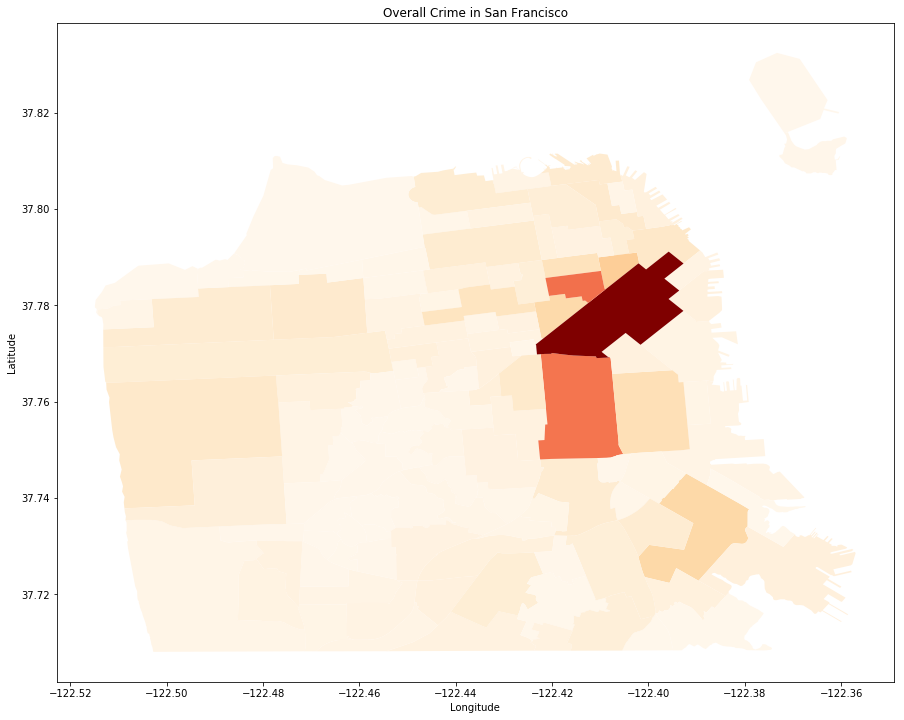

In [26]:
#Create a map of overall crime in San Francisco
per_county.plot(column = "count", cmap = "OrRd", figsize = (15,15), zorder = 1)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Overall Crime in San Francisco")
#counties.apply(add_label, axis =1) #doesn't work?
plt.show()

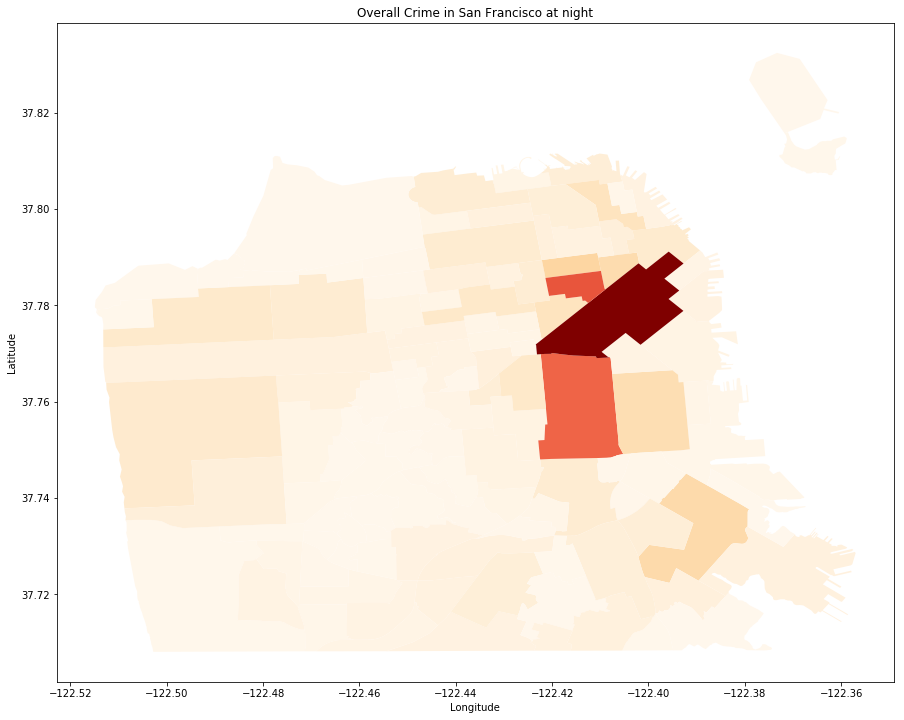

In [27]:
#Join for night subset
joined_night = gpd.sjoin(counties, crimes_night, how = "left", op = "contains")

#Group by and aggregate for the night subset
per_county_night = joined_night.groupby("name").agg({
    "name": "count",
    "geometry": "first"
})
per_county_night.reset_index(drop=True , inplace = True)
per_county_night.rename(columns = {"name": "count"}, inplace = True)

#Createa a GeoDataFrame
per_county_night = gpd.GeoDataFrame(per_county_night)

#Plot the night subset 
per_county_night.plot(column = "count", cmap = "OrRd", figsize = (15,15), zorder = 1)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Overall Crime in San Francisco at night")
#counties.apply(add_label, axis =1) #doesn't work?
plt.show()

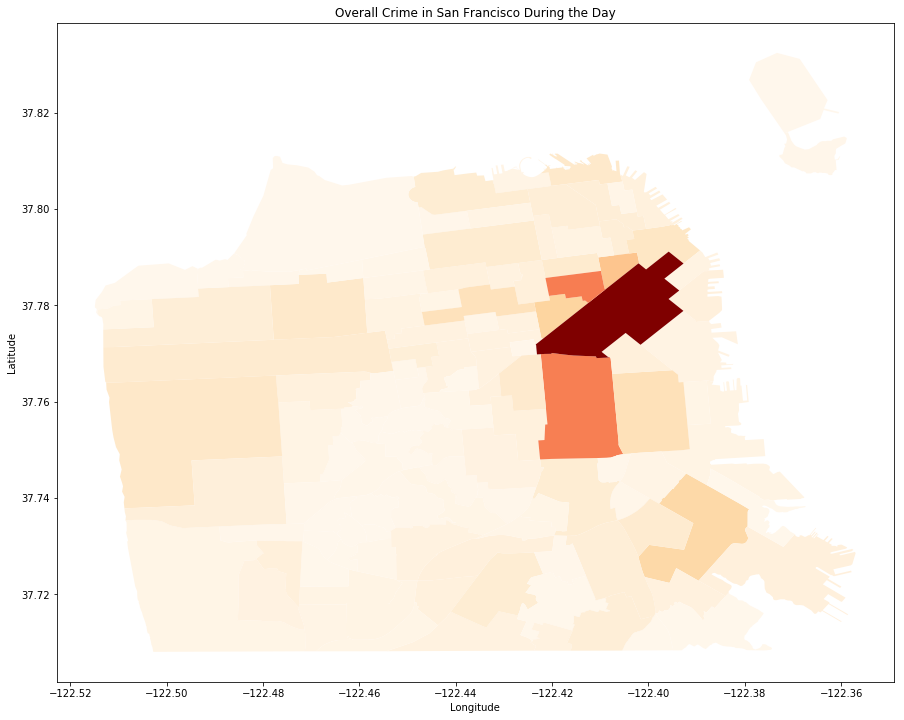

In [28]:
# Join for day subset and aggregate/groupby
joined_day = gpd.sjoin(counties, crimes_day, how = "left", op = "contains")

per_county_day = joined_day.groupby("name").agg({
    "name": "count",
    "geometry": "first"
})
per_county_day.reset_index(drop=True , inplace = True)
per_county_day.rename(columns = {"name": "count"}, inplace = True)

#create GeoDataFrame for day subset
per_county_day = gpd.GeoDataFrame(per_county_day)

#Plot day subset
per_county_day.plot(column = "count", cmap = "OrRd", figsize = (15,15), zorder = 1)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Overall Crime in San Francisco During the Day")
counties.apply(add_label, axis =1)
plt.show()

In [29]:
#Get the highest counties

print(counties.iloc[30,:])
print(counties.iloc[50,:])
print(counties.iloc[18,:])

link             http://www.sfgate.com/neighborhoods/sf/soma/
name                                          South of Market
geometry    POLYGON ((-122.3958134209999 37.79115280800005...
Name: 30, dtype: object
link          http://www.sfgate.com/neighborhoods/sf/mission/
name                                                  Mission
geometry    POLYGON ((-122.4223648179999 37.76986769700005...
Name: 50, dtype: object
link        http://www.sfgate.com/neighborhoods/sf/tenderl...
name                                               Tenderloin
geometry    POLYGON ((-122.4098740169999 37.78714914200009...
Name: 18, dtype: object


link        http://www.sfgate.com/neighborhoods/sf/goldeng...
name                                         Golden Gate Park
geometry    POLYGON ((-122.5131405409999 37.77133111500007...
Name: 8, dtype: object
link        http://sanfrancisco.about.com/od/neighborhoodp...
name                                       Financial District
geometry    POLYGON ((-122.4029573609999 37.79377985700006...
Name: 107, dtype: object
link        http://www.sfgate.com/neighborhoods/sf/unionsq...
name                                  Downtown / Union Square
geometry    POLYGON ((-122.4023804019999 37.79096861000005...
Name: 17, dtype: object


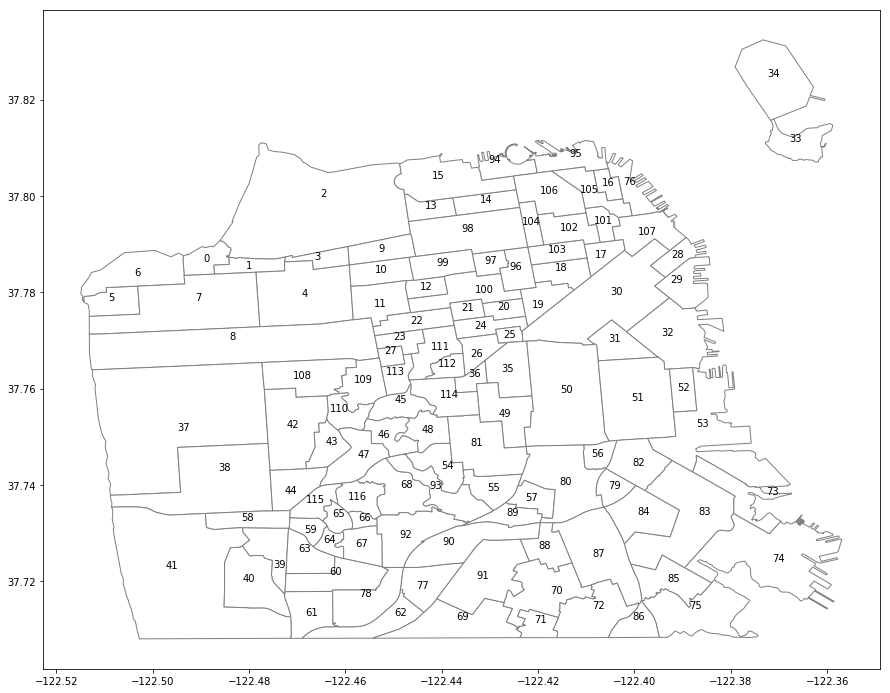

In [30]:
#plot the county numbers on a map
ax = counties.plot(color = "white", edgecolor = "gray",figsize = (15,15))
counties.apply(add_label, axis =1)
plt.show

#Get the intersting counties
print(counties.iloc[8,:])
print(counties.iloc[107,:])
print(counties.iloc[17,:])

### Which parts of the city have the highest amounts of crimes (and at what times)?
    
    I decided to analyze this problem by creating chlorpleth maps for overall crime, they to split the crime by day and night.  To designate day vs night; day was allocated to the times between 6am and 8pm, and night was allocated to the times between 8pm and 6am.  We see from the 3 chloropleth plots above that the concentration of crime for the areas with the highest amount of crime doesnt change, with the "South of Market" region being the area with the highest amount of crime.  It's surrounding districts, "Mission" and "Tenderloin" also have fairly high amounts of crime.  The distinction between night and day, doesn't change this, but there are a few things that can be noticed between night and day when looking outside of the highest crime areas.  This districts of "Downtown", "Golden Gate Park" and "Financial District" tend to have higher amounts of crimes during the day that at night, which is expected when you account for the fact that commercial areas, and major parks will have fewer concentrations of people during night than during the day. 

In [31]:
#4 Do the housing prices by region change over time?

In [32]:
#pd.read_sql("SELECT * FROM sqlite_master", db)

In [33]:
#read in the zillow data and for each year load it in
#I know there is an easier way to do this, but with how my code is set up, this was quicker

zillow = pd.read_sql("SELECT * FROM zillow", db)
zillow11 = pd.read_sql("SELECT * FROM zillow WHERE date LIKE '2011%'", db)
zillow12 = pd.read_sql("SELECT * FROM zillow WHERE date LIKE '2012%'", db)
zillow13 = pd.read_sql("SELECT * FROM zillow WHERE date LIKE '2013%'", db)
zillow14 = pd.read_sql("SELECT * FROM zillow WHERE date LIKE '2014%'", db)
zillow15 = pd.read_sql("SELECT * FROM zillow WHERE date LIKE '2015%'", db)
zillow16 = pd.read_sql("SELECT * FROM zillow WHERE date LIKE '2016%'", db)

#Create a list of postal codes in zillow
post_set = list(zillow.RegionName.unique())


In [34]:
#Read in the shape file for postal codes in the country
post_codes = gpd.read_file("cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")

#Convert them to numeric
post_codes["ZCTA5CE10"] = pd.to_numeric(post_codes["ZCTA5CE10"])

In [35]:
#Create an empty list
pos = []

#For loop to collect the list of postal codes in san francisco
for i in range(len(post_codes)):
    t = post_codes["ZCTA5CE10"][i] in post_set
    pos.append([t])
    
#Get just the postal codes that we need for San Fran
post_codes = post_codes[pos]

In [36]:
def plot_zillow(zil, year):
    """Function:
            This funciton takes a zillow file and mergest it with postal codes, removes the incorrect postal codes and plots
        
        Input:
            Zillow (pandas data set), year (string)
        
        output:
            None, but it plots the zillow data set
    """
    
    #groupby mean and reset index
    zgm = zil.groupby("RegionName").mean()
    zgm = zgm.reset_index()
    
    #Read in postal codes, converty to numeric, and turn in to a list
    post_codes = gpd.read_file("cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")
    post_codes["ZCTA5CE10"] = pd.to_numeric(post_codes["ZCTA5CE10"])
    post_set = list(zil.RegionName.unique())
    
    #Dummy variable for for loop
    pos = []
    
    #for loop to extract postal codes
    for i in range(len(post_codes)):
        t = post_codes["ZCTA5CE10"][i] in post_set
        pos.append([t])
    
    #Get just the postal codes for san fran
    post_codes = post_codes[pos]
    
    #Reset index for postal codes
    post_codes = post_codes.reset_index()
    
    #Merge postal codes and 'zillow group by mean'
    zgm_post = post_codes.merge(zgm, right_on = "RegionName", left_on = "ZCTA5CE10")
    
    #Remove extranious values & outlier to make it easier to see
    zgm_post = zgm_post.drop([20])
    
    #plot chloropleth
    zgm_post.plot(column = "MedianSoldPricePerSqft_AllHomes", figsize = (10,10))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Median Housing Price Per Postal Code For " + year)
    plt.show()

In [37]:
zgm = zillow.groupby("RegionName").mean()
zgm = zgm.reset_index()
post_codes = post_codes.reset_index()

In [38]:
zgm_post = post_codes.merge(zgm, right_on = "RegionName", left_on = "ZCTA5CE10")

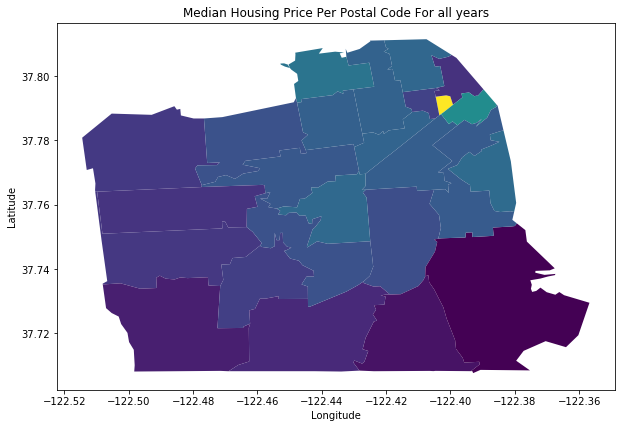

In [39]:
#zgm2 = zgm_post.iloc[:,[2,5,11]]

#Remove outlier and plot
zgm_post = zgm_post.drop([20])
zgm_post.plot(column = "MedianSoldPricePerSqft_AllHomes", figsize = (10,10))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Median Housing Price Per Postal Code For all years")
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


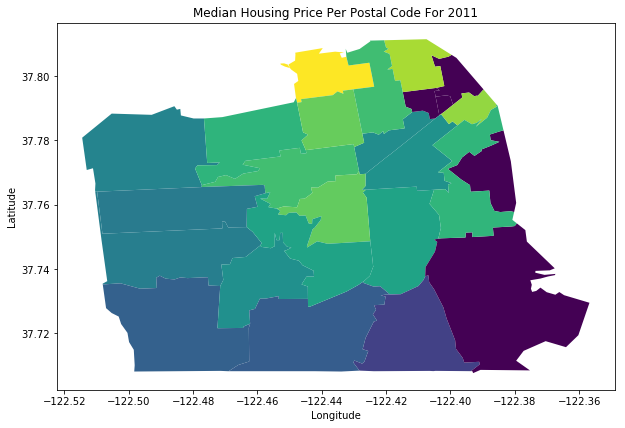

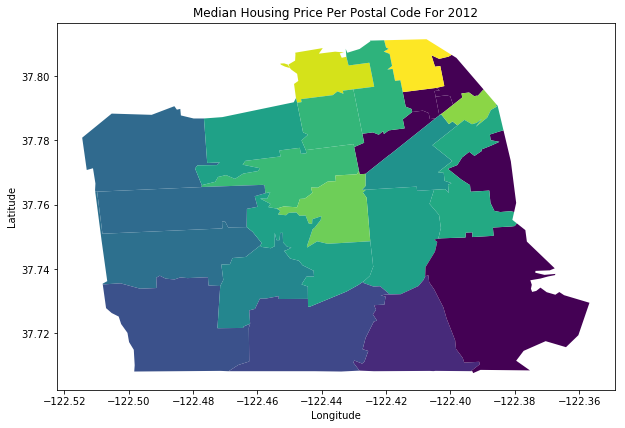

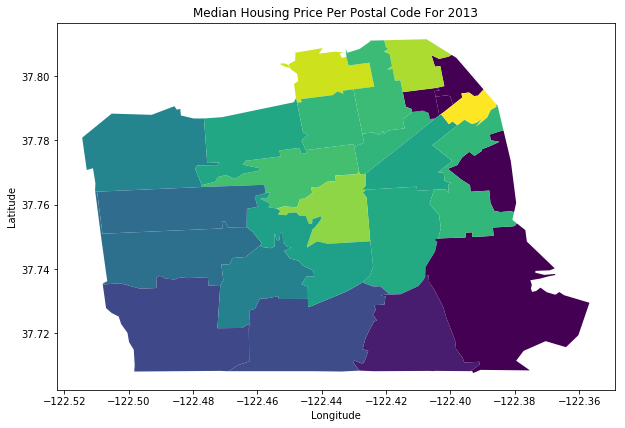

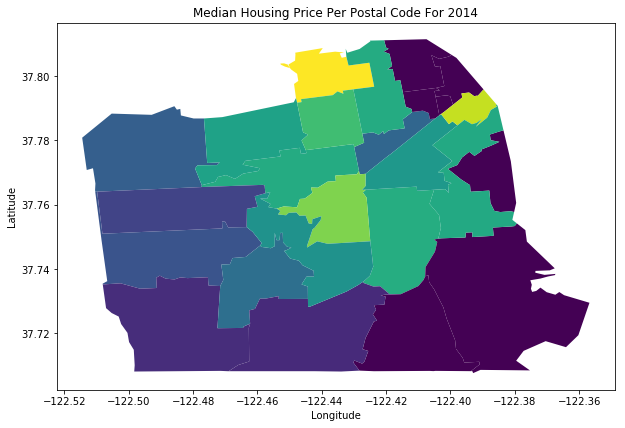

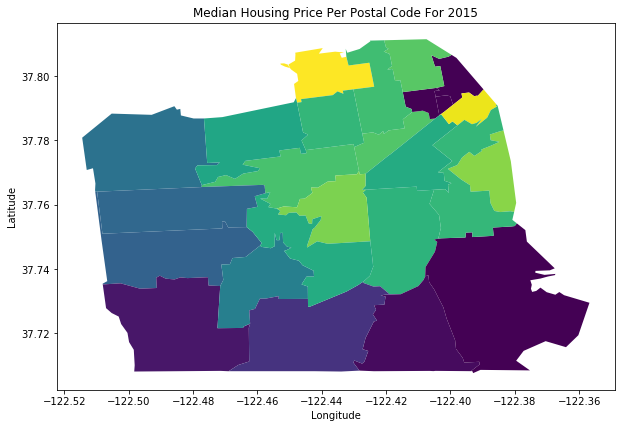

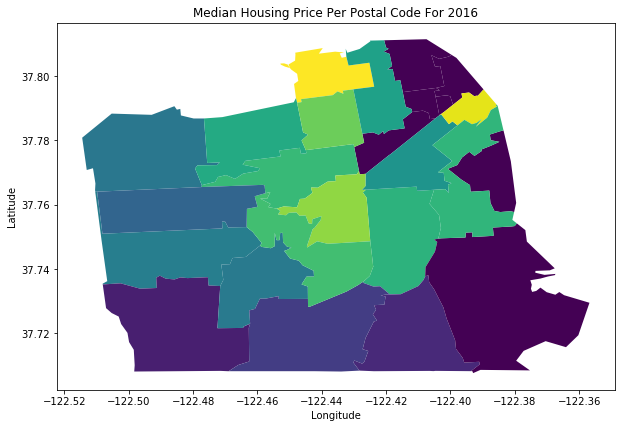

In [40]:
#Plot all of the zillow

plot_zillow(zillow11, "2011")
plot_zillow(zillow12, "2012")
plot_zillow(zillow13, "2013")
plot_zillow(zillow14, "2014")
plot_zillow(zillow15, "2015")
plot_zillow(zillow16, "2016")

### Where arethe most expensive regions? Do the housing prices by region change over time in relation to eachother?

    To analyze this, I chose to create an overall chloropleth map for the average median housing price per square foot sold in each respective postal code.  I then created one for earch respective year between 2011 and 2017 to compare how the postal codes housing prices changed over time.  We know that the median price of housing went up by over 70% throughout the whole region (which can be seen in problem 2.1), and we can see that the mean median housing price per square foot sold has because more extreme in the city between postal codes.  Between 2011 and 2016 we see that the difference in mean median housing price has become more extreme between the Southern and Western portions of San Francisco vs the Central/North East downtown area.  The most expensive postal codes tend to be the ones located in the Central/North Eastern portion of San Francisco near the downtown area, with the 94104 postal code being the most expensive, with an average median housing price per square foot of $1336.  The postal codes tend to get less expensive as you get futehr away from the downtwon area in the North Eastern portion of San Francisco, especially the 94124 postal code, which has an average median housing price per square foot sold of $297, which is 77.7% cheaper than the most expensive postal code in San Francisco. 

In [41]:
#5  Schools and Parks locations related? (What types of parks?) (Also do certain types of parks tend to be in higher wealth areas?)

In [42]:
# Read in Parks Data
parks = pd.read_sql("SELECT Lat,Lon FROM parks", db)
parks_mini = pd.read_sql("SELECT Lat,Lon FROM parks WHERE type = 'Mini Park'", db)
parks_np = pd.read_sql("SELECT Lat,Lon FROM parks WHERE type = 'Neighborhood Park or Playground'", db)
parks_reg = pd.read_sql("SELECT Lat,Lon FROM parks WHERE type = 'Regional Park'", db)

In [43]:
# Read in School Data

schools = pd.read_sql("SELECT Lat,Lon FROM schools", db)

In [44]:
def parks_to_geo(park):
    """Function takes in park data and removes extranious data then converts it into a geopandas data frame
        
        input:
            park (Pandas DataFrame)
            
        output:
            park_geo (GeoPandas DataFrame)
    """
    park_lnglat = [geom.Point(x) for x in zip(park["Lon"], park["Lat"])]
    park_geo = gpd.GeoDataFrame(park, geometry = park_lnglat)
    park_geo = park_geo.dropna()
    park_geo = park_geo[(park_geo["Lon"] < -120) & (park_geo["Lat"] > 37.7)]
    return(park_geo)
    

In [45]:
#Counties shapefile for plotting
counties = gpd.read_file("SF Find Neighborhoods/geo_export_96bb9dad-f9fb-4df0-969b-f467d0b5d405.shp")

In [46]:
#Create geo for each park and schools

parks_geo = parks_to_geo(parks)
parks_mini_geo = parks_to_geo(parks_mini)
parks_np_geo = parks_to_geo(parks_np)
parks_reg_geo = parks_to_geo(parks_reg)
schools_geo = parks_to_geo(schools)


<function matplotlib.pyplot.show>

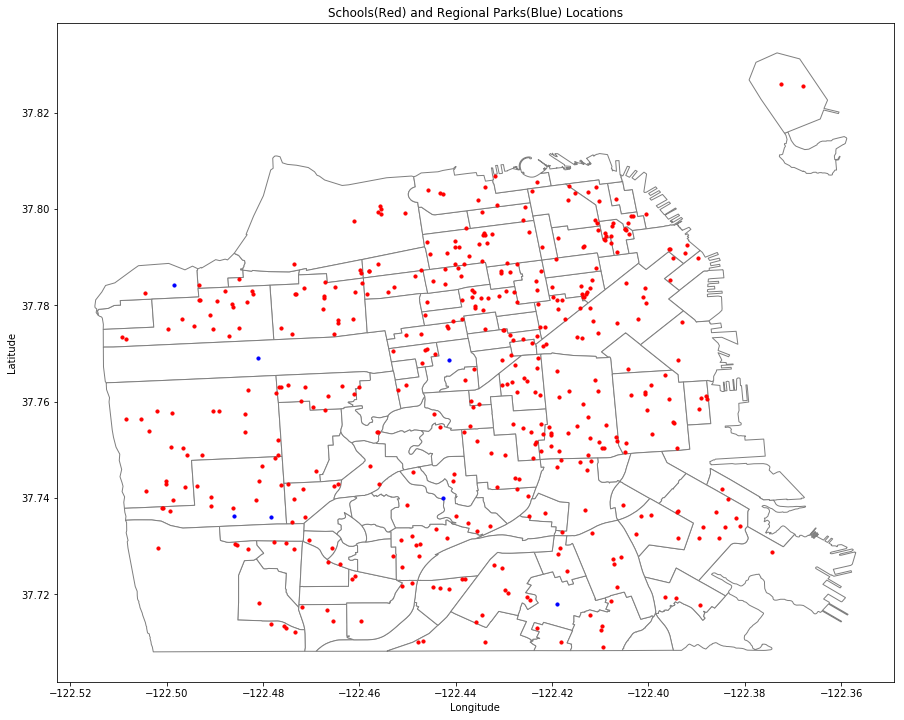

In [47]:
#Plot Regional Parks & schools
ax = counties.plot(color = "white", edgecolor = "gray",figsize = (15,15))
schools_geo.plot(ax = ax, color = "red", alpha = 1, markersize = 10)
parks_reg_geo.plot(ax = ax, color = "blue", alpha = 1, markersize = 10)
plt.title("Schools(Red) and Regional Parks(Blue) Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#counties.apply(add_label, axis  = 1)
plt.show

<function matplotlib.pyplot.show>

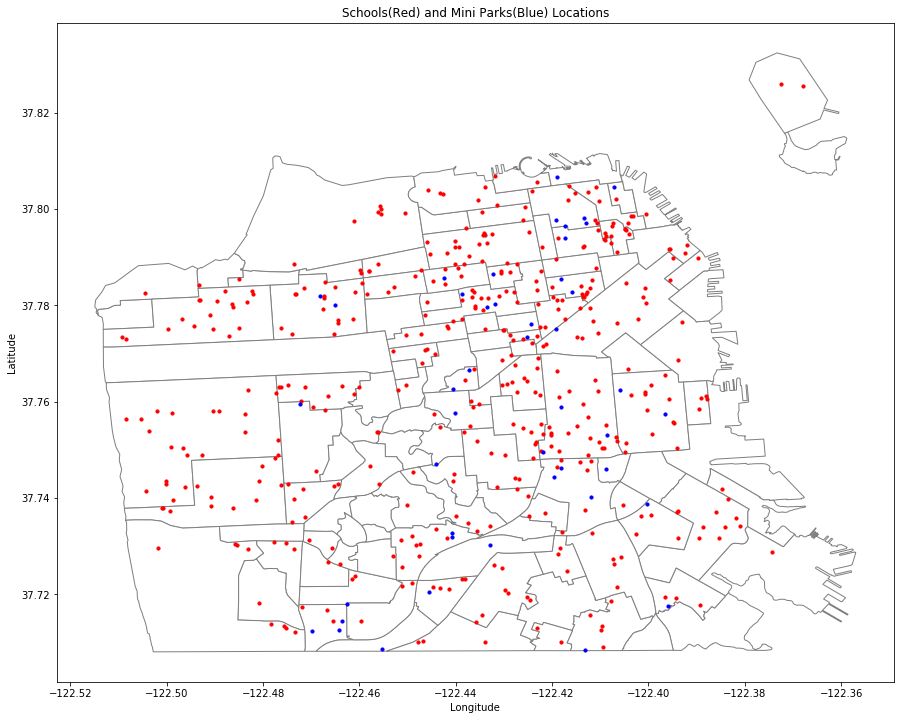

In [48]:
#Plot mini Parks & schools
ax = counties.plot(color = "white", edgecolor = "gray",figsize = (15,15))
schools_geo.plot(ax = ax, color = "red", alpha = 1, markersize = 10)
parks_mini_geo.plot(ax = ax, color = "blue", alpha = 1, markersize = 10)
plt.title("Schools(Red) and Mini Parks(Blue) Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#counties.apply(add_label, axis  = 1)
plt.show

<function matplotlib.pyplot.show>

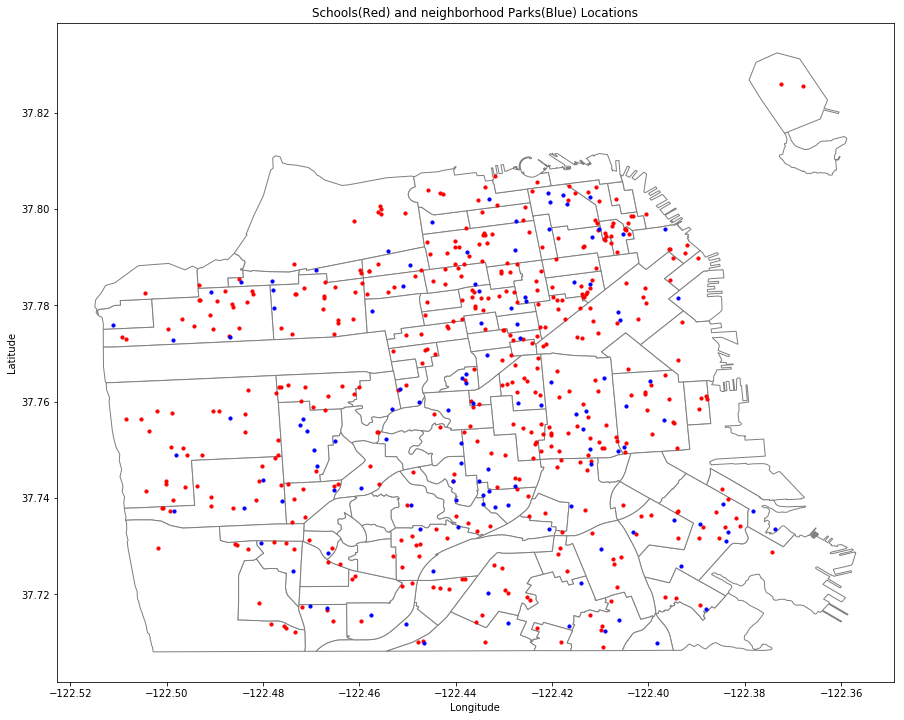

In [49]:
#Plot Regional Parks & schools
ax = counties.plot(color = "white", edgecolor = "gray",figsize = (15,15))
schools_geo.plot(ax = ax, color = "red", alpha = 1, markersize = 10)
parks_np_geo.plot(ax = ax, color = "blue", alpha = 1, markersize = 10)
plt.title("Schools(Red) and neighborhood Parks(Blue) Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#counties.apply(add_label, axis  = 1)
plt.show

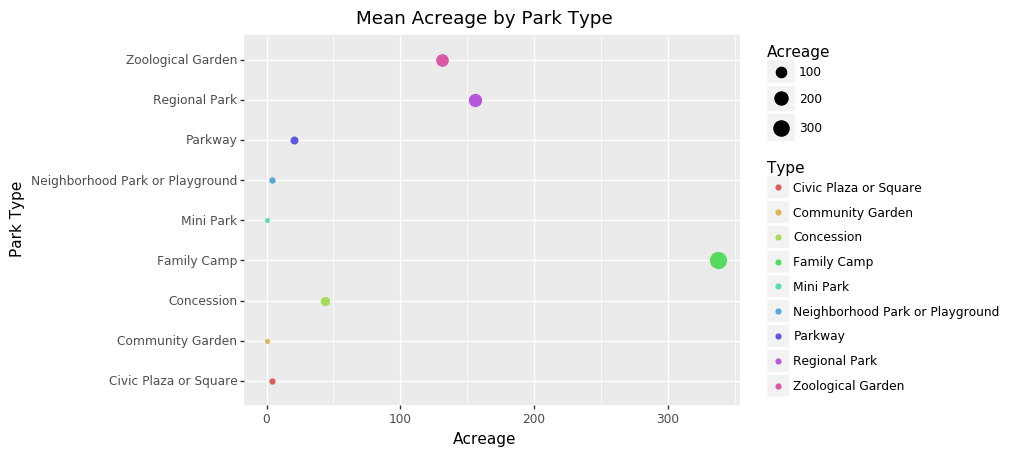

<ggplot: (-9223372029304780947)>

In [50]:
#Read in parks data  and groupby park type
parks2 = pd.read_sql("SELECT * FROM parks", db)
parks2 = parks2.groupby("Type").mean()
parks2 = parks2.reset_index()

#Use Plotnine to create a dotplot for Park Type vs Acreage
p = gg.ggplot(parks2, gg.aes("Type","Acreage", color = "Type", size = "Acreage")) + gg.geom_point()
p = p + gg.coord_flip()
p + gg.labs(x = "Park Type", title = "Mean Acreage by Park Type")

In [51]:
parks2

,Type,Acreage,ParkID,Lat,Lon
0,Civic Plaza or Square,4.373000,133.900000,37.792352,-122.413852
1,Community Garden,0.316111,100932.222222,37.752954,-122.427614
2,Concession,43.620000,115.500000,37.760619,-122.403050
3,Family Camp,337.510000,10379.000000,37.881602,-119.850760
4,Mini Park,0.276000,17843.288889,37.759159,-122.430006
5,Neighborhood Park or Playground,4.422748,2293.419847,37.756729,-122.435421
6,Parkway,20.740000,132.000000,37.749281,-122.508175
7,Regional Park,155.626842,239535.157895,37.734595,-122.466079
8,Zoological Garden,131.520000,12.000000,37.731589,-122.503809


###  Schools and Parks locations related? (What types of parks?) (Also, are some parks larger than others?) (Are some located in different areas? Why?)

    To analyze this problem I decided to create maps of San Francisco comparing the locations of schools with parks, and then creating further maps to see if certain parks were more closely associated with schools than other.  From the above map plots comparing parks and school locations, we see that "Mini Parks" tend to be located close to schools, we see a similar scenario with "Neighborhood Parks", maybe just slightly less so.  "Regional Parks" on the other hand, tend to be located away from schools. An interesting observation can be made when comparing these maps with the plots from the previous question regarding real estate expenses.  While, "mini parks" and "neighborhood parks" tend to be dispersed throughout the entire city, "Regional Parks" are exctlusively located outside of the most expensive areas in the city.  One reason for this might be that these parks are State Parks, and are therefor located in areas absent of large commercial infrastructure, thus leading them to be less lucrative. Looking at the dot pot comparing the sizes of parks, we see that by far, "Family Camp" parks are the largest on average, with an average acreage of 337 acres, and "mini parks" and and "community Gardens" being the smallest, both averaging at less than half an acre. 